<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Training-on-A1-BenchMark-data" data-toc-modified-id="Training-on-A1-BenchMark-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Training on A1 BenchMark data</a></span></li></ul></div>

In [3]:
import numpy as np
import matplotlib.pyplot as plt                        
import torch
import pandas as pd
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

,sinewave
time,
0,0.841471
1,0.873736
2,0.902554
3,0.927809
4,0.949402


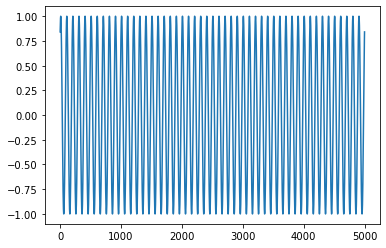

In [270]:
sinewave = pd.read_csv('./sinewave.csv',index_col = 0)
sinewave = sinewave.astype('float')
plt.plot(sinewave)
sinewave.head()

In [271]:
"""Hyperparameters"""
w = 2000                 # History window (number of time stamps taken into account) 
                         # i.e., filter(kernel) size       
p_w = 300                # Prediction window (number of time stampes required to be 
                         # predicted)
n_features = 1           # Univariate time series

kernel_size = 2          # Size of filter in conv layers
num_filt_1 = 32          # Number of filters in first conv layer
num_filt_2 = 32          # Number of filters in second conv layer
num_nrn_dl = 40          # Number of neurons in dense layer
num_nrn_ol = p_w         # Number of neurons in output layer

conv_strides = 1
pool_size_1 = 2          # Length of window of pooling layer 1
pool_size_2 = 2          # Length of window of pooling layer 2
pool_strides_1 = 2       # Stride of window of pooling layer 1
pool_strides_2 = 2       # Stride of window of pooling layer 2


epochs = 30
dropout_rate = 0.2       # Dropout rate in the fully connected layer
learning_rate = 2e-5
anm_det_thr = 0.8        # Threshold for classifying anomaly (0.5~0.8)

In [272]:
def get_subsequences(data):
    X = []
    Y = []
    
    for i in range(len(data) - w -p_w):
        X.append(data[i:i+w])
        Y.append(data[i+w:i+w+p_w])
    return np.array(X),np.array(Y)

batch_sample, batch_label = get_subsequences(list(sinewave['sinewave']))
batch_sample = np.reshape(batch_sample,(batch_sample.shape[0],batch_sample.shape[1],n_features))
train_data = (batch_sample,batch_label)
loader = torch.utils.data.DataLoader(train_data)

In [310]:
#  CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## layers of a CNN
        
        self.conv1 = nn.Conv1d(1,num_filt_1,kernel_size,conv_strides,padding = 0)
        
        self.conv2 = nn.Conv1d(num_filt_1,num_filt_2,kernel_size,conv_strides,padding = 0)

        self.maxpool = nn.MaxPool1d(pool_size_1)
        
        self.lin1 = nn.Linear(int(0.25* (w-4) * num_filt_2),num_nrn_dl )
        self.lin2 = nn.Linear(num_nrn_dl,p_w)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):

        
        #convolution layer 1
        x = (F.relu(self.conv1(x)))
        x = self.maxpool(x)
             
        #convolution layer 2
        x = (F.relu(self.conv2(x)))
        x = self.maxpool(x)

        print(x.shape)
        x = x.view(-1,int(0.25* (w-4) * num_filt_2))
        
        x = self.dropout(x)
        x = (F.relu(self.lin1(x)))
        x = self.dropout(x)
        x = (F.relu(self.lin2(x)))
        
        return x
    
model_scratch = Net()
print(model_scratch)
  

Net(
  (conv1): Conv1d(1, 32, kernel_size=(2,), stride=(1,))
  (conv2): Conv1d(32, 32, kernel_size=(2,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lin1): Linear(in_features=328, out_features=40, bias=True)
  (lin2): Linear(in_features=40, out_features=300, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [274]:
criterion_scratch = nn.L1Loss()
optimizer_scratch = optim.Adam(model_scratch.parameters())#, lr=learning_rate)
#optimizer_scratch = optim.SGD(model_scratch.parameters(),lr = learning_rate, momentum=0.9,weight_decay=1e-6)

In [275]:
def train(n_epochs, data,target, model, optimizer, criterion):
    """returns trained model"""

    target = torch.tensor(target).type('torch.FloatTensor')
    data = np.reshape(data,(data.shape[0],data.shape[2],data.shape[1]))
    data = torch.tensor(data).type('torch.FloatTensor')
    
    train_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        
        ###################
        # training the model #
        ###################
        model.train()

        #print(data.shape)


        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss = loss.item()

        if(epoch%5 == 0):
            print('Epoch: {} \tTraining Loss: {:.6f}'.format(
                epoch, 
                train_loss,
                ))


    return model


In [276]:
model_scratch = train(100, batch_sample,batch_label, model_scratch, optimizer_scratch, 
                      criterion_scratch)

Epoch: 5 	Training Loss: 0.622603
Epoch: 10 	Training Loss: 0.606197
Epoch: 15 	Training Loss: 0.589282


KeyboardInterrupt: 

In [235]:
n_test_seq = 1

def generate_test_seq(data, n_test_seq,seed = 0):
    np.random.seed(0)
    rand_idx = np.random.randint(0,len(data) - n_test_seq * w - n_test_seq * p_w)
    test_seq = np.array(data[rand_idx:rand_idx + n_test_seq * w +  n_test_seq * p_w])
    batch_test_seq, batch_test_label = list(), list()
    ix = rand_idx
    for i in range(n_test_seq):
        seq_x = data[ix : ix+w],
        seq_y = data[ix+w : ix+w+p_w]
        ix = ix+w+p_w
        batch_test_seq.append(seq_x)
        batch_test_label.append(seq_y)
    return np.array(batch_test_seq), np.array(batch_test_label)

batch_test_seq, batch_test_label = generate_test_seq(list(sinewave['sinewave']), n_test_seq)

In [236]:
def test_model(model,data,target):
    target = torch.tensor(target).type('torch.FloatTensor')
    #data = np.reshape(data,(data.shape[0],data.shape[2],data.shape[1]))
    data = torch.tensor(data).type('torch.FloatTensor')
    
    model.eval()
    
    output = model(data)
    loss = criterion_scratch(output, target)
    loss_val = loss.item()
    print('Testing Loss ',loss_val)


In [237]:
test_model(model_scratch,batch_test_seq,batch_test_label)

Testing Loss  0.3913981318473816


# Training on A1 BenchMark data

In [155]:
ts_data = pd.read_csv('./A1Benchmark/real_60.csv',index_col = 0)
#ts_data = ts_data.astype('float')
ts_data.head()

,value,is_anomaly
timestamp,,
1,1.265278,0
2,1.100833,0
3,1.147778,0
4,1.053889,0
5,1.051944,0


In [156]:
ts_data[['is_anomaly','value']].groupby('is_anomaly').count()

,value
is_anomaly,
0,1445
1,16


In [157]:
ts_data.shape

(1461, 2)

In [158]:
train_percent = int(0.3*len(ts_data))
valid_percent = int(0.1*len(ts_data))
test_percent = int(0.6*len(ts_data))

train_data = list(ts_data.iloc[:train_percent,0])
valid_data = list(ts_data.iloc[train_percent:train_percent+valid_percent,0])
test_data = list(ts_data.iloc[train_percent+valid_percent:,0])


In [159]:
w = 45
pred_window = 1
filter1_size = 128
filter2_size = 32
kernel_size = 2
stride = 1
pool_size = 2

In [160]:


def get_subsequences(data):
    X = []
    Y = []
    
    for i in range(len(data) - w -pred_window):
        X.append(data[i:i+w])
        Y.append(data[i+w:i+w+pred_window])
    return np.array(X),np.array(Y)

trainX,trainY = get_subsequences(train_data)
trainX = np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))

validX,validY = get_subsequences(valid_data)
validX = np.reshape(validX,(validX.shape[0],1,validX.shape[1]))

testX,testY = get_subsequences(test_data)
testX = np.reshape(testX,(testX.shape[0],1,testX.shape[1]))


In [161]:
#  CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## layers of a CNN
        
        self.conv1 = nn.Conv1d(1,filter1_size,kernel_size,stride,padding = 0)
        
        self.conv2 = nn.Conv1d(filter1_size,filter2_size,kernel_size,stride,padding = 0)

        self.maxpool = nn.MaxPool1d(pool_size)
        
        self.dim1 = int(0.5*(0.5*(w-1)-1)) * filter2_size
        
        self.lin1 = nn.Linear(self.dim1,pred_window )
        #self.lin2 = nn.Linear(1000,pred_window)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):

        
        #convolution layer 1
        x = (F.relu(self.conv1(x)))
        x = self.maxpool(x)
        #print(x.shape)
        #x = self.dropout(x)


             
        #convolution layer 2
        x = (F.relu(self.conv2(x)))
        x = self.maxpool(x)
        #x = self.dropout(x)

        #print(x.shape)


        #print(x.shape)
        #print(int(0.25* (w) * filter2_size))
        x = x.view(-1,self.dim1)
        
        x = self.dropout(x)
        x = self.lin1(x)
        #x = self.dropout(x)
        #x = self.lin2(x)

        
        return x

  

In [162]:
model_A1 = Net()
print(model_A1)

Net(
  (conv1): Conv1d(1, 128, kernel_size=(2,), stride=(1,))
  (conv2): Conv1d(128, 32, kernel_size=(2,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lin1): Linear(in_features=320, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [163]:
criterion_scratch = nn.L1Loss()
optimizer_scratch = optim.Adam(model_A1.parameters(), lr = 1e-5,weight_decay=1e-6)

In [164]:
def train_valid(n_epochs, trainX,trainY, validX,validY,model, optimizer, criterion,save_path,freq = 5):
    """returns trained model"""

    target_train = torch.tensor(trainY).type('torch.FloatTensor')
    data_train = torch.tensor(trainX).type('torch.FloatTensor')
    
    target_valid = torch.tensor(validY).type('torch.FloatTensor')
    data_valid = torch.tensor(validX).type('torch.FloatTensor')
    
    train_loss_min = np.Inf
    valid_loss_min = np.Inf
    last_valid_loss= 0
    
    for epoch in range(1, n_epochs+1):
        
        ###################
        # training the model #
        ###################
        model.train()

        #print(data.shape)


        optimizer.zero_grad()
        output = model(data_train)
        loss = criterion(output, target_train)
        loss.backward()
        optimizer.step()
        train_loss = loss.item()
        
        ###################
        # Validation #
        ###################
        model.eval()
        output_valid = model(data_valid)
        
        loss_valid = criterion(output_valid, target_valid)
        valid_loss = loss_valid.item()
        if(valid_loss == last_valid_loss):
            print('problem')
            
        last_valid_loss = valid_loss
        if(epoch%freq == 0):
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                epoch, 
                train_loss,
                valid_loss
                ))
            
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
        


    return model,output


In [166]:
model_A1,out = train_valid(500, trainX,trainY,validX,validY, model_A1, optimizer_scratch, 
                      criterion_scratch, 'model_A1.pt',freq = 10)

Validation loss decreased (inf --> 0.199891).  Saving model ...
Epoch: 10 	Training Loss: 0.160171 	Validation Loss: 0.200192
Epoch: 20 	Training Loss: 0.159312 	Validation Loss: 0.200439
Epoch: 30 	Training Loss: 0.165244 	Validation Loss: 0.200615
Epoch: 40 	Training Loss: 0.164555 	Validation Loss: 0.200792
Epoch: 50 	Training Loss: 0.167510 	Validation Loss: 0.200920
Epoch: 60 	Training Loss: 0.174983 	Validation Loss: 0.200940
Epoch: 70 	Training Loss: 0.171367 	Validation Loss: 0.200916
Epoch: 80 	Training Loss: 0.169199 	Validation Loss: 0.200847
Epoch: 90 	Training Loss: 0.162067 	Validation Loss: 0.200852
Epoch: 100 	Training Loss: 0.163939 	Validation Loss: 0.200860
Epoch: 110 	Training Loss: 0.174090 	Validation Loss: 0.200779
Epoch: 120 	Training Loss: 0.169917 	Validation Loss: 0.200720
Epoch: 130 	Training Loss: 0.173761 	Validation Loss: 0.200570
Epoch: 140 	Training Loss: 0.163403 	Validation Loss: 0.200352
Epoch: 150 	Training Loss: 0.164011 	Validation Loss: 0.200166


Validation loss decreased (0.197151 --> 0.197113).  Saving model ...
Validation loss decreased (0.197113 --> 0.197078).  Saving model ...
Validation loss decreased (0.197078 --> 0.197045).  Saving model ...
Validation loss decreased (0.197045 --> 0.197012).  Saving model ...
Validation loss decreased (0.197012 --> 0.196983).  Saving model ...
Epoch: 270 	Training Loss: 0.165181 	Validation Loss: 0.196946
Validation loss decreased (0.196983 --> 0.196946).  Saving model ...
Validation loss decreased (0.196946 --> 0.196907).  Saving model ...
Validation loss decreased (0.196907 --> 0.196865).  Saving model ...
Validation loss decreased (0.196865 --> 0.196819).  Saving model ...
Validation loss decreased (0.196819 --> 0.196787).  Saving model ...
Validation loss decreased (0.196787 --> 0.196751).  Saving model ...
Validation loss decreased (0.196751 --> 0.196718).  Saving model ...
Validation loss decreased (0.196718 --> 0.196694).  Saving model ...
Validation loss decreased (0.196694 --> 

Epoch: 390 	Training Loss: 0.158186 	Validation Loss: 0.193937
Validation loss decreased (0.193960 --> 0.193937).  Saving model ...
Validation loss decreased (0.193937 --> 0.193917).  Saving model ...
Validation loss decreased (0.193917 --> 0.193900).  Saving model ...
Validation loss decreased (0.193900 --> 0.193875).  Saving model ...
Validation loss decreased (0.193875 --> 0.193853).  Saving model ...
Validation loss decreased (0.193853 --> 0.193832).  Saving model ...
Validation loss decreased (0.193832 --> 0.193819).  Saving model ...
Validation loss decreased (0.193819 --> 0.193791).  Saving model ...
Validation loss decreased (0.193791 --> 0.193761).  Saving model ...
Validation loss decreased (0.193761 --> 0.193728).  Saving model ...
Epoch: 400 	Training Loss: 0.165481 	Validation Loss: 0.193692
Validation loss decreased (0.193728 --> 0.193692).  Saving model ...
Validation loss decreased (0.193692 --> 0.193652).  Saving model ...
Validation loss decreased (0.193652 --> 0.1936

Validation loss decreased (0.190434 --> 0.190398).  Saving model ...
Validation loss decreased (0.190398 --> 0.190359).  Saving model ...
Epoch: 500 	Training Loss: 0.152464 	Validation Loss: 0.190322
Validation loss decreased (0.190359 --> 0.190322).  Saving model ...


In [167]:
model_A1.load_state_dict(torch.load('model_A1.pt'))

<All keys matched successfully>

In [173]:
test_tensor =  torch.tensor(testX).type('torch.FloatTensor')
model_A1.eval()
out = model_A1(test_tensor)
out = out.detach().numpy()


In [174]:
df_out = pd.DataFrame()
df_out['pred'] = out[:,0]
df_out['actual'] = testY[:,0]
#df_out.index = ts_data.index[train_percent + valid_percent:len(ts_data)-w-pred_window]

df_out.tail()

,pred,actual
826,0.991928,2.354444
827,1.026948,2.680556
828,1.042136,3.063889
829,1.053000,2.462778
830,1.077224,1.616667


In [175]:
df_out['error'] = np.abs(df_out['pred'] - df_out['actual'])
df_out['error_n'] = (df_out['error'] - df_out['error'].mean())/df_out['error'].std()
df_out.index = ts_data.index[train_percent + valid_percent +w+pred_window-1:-1]

In [185]:
thresh = df_out.loc[df_out['error_n'].abs() > 3]
thresh

,pred,actual,error,error_n
timestamp,,,,
844,0.897088,3.982222,3.085135,6.244851
1208,1.060543,5.646111,4.585568,9.527006
1209,1.069160,10.452778,9.383618,20.022597
1210,1.119900,4.237778,3.117878,6.316476
1211,1.099984,3.192222,2.092238,4.072920
1457,1.026948,2.680556,1.653607,3.113428
1458,1.042136,3.063889,2.021753,3.918736


In [186]:
positives = ts_data.loc[df_out.index].loc[ts_data.is_anomaly == 1].index
negatives = ts_data.loc[df_out.index].loc[ts_data.is_anomaly == 0].index
tp = []
fn = []
fp = []
tn = []
for p in positives:
    if p in thresh.index:
        tp.append(p)
    else:
        fn.append(p)

for n in negatives:
    if n in thresh.index:
        fp.append(n)
    else:
        tn.append(n)

In [187]:
recall = len(tp)/(len(tp)+len(fn))
precision = len(tp)/(len(tp)+len(fp))
F_score = 2* recall*precision/(recall + precision)
F_score

0.7777777777777778